# Synthetic Data Generation

## Preliminaries

In [1]:
# imports 
import sys
sys.path.append("/Users/audreymcmillion/Documents/acm-thesis") 
from ev_scoring import ExtremeValueScoring
from market_utils import MarketUtilities
from ydata.connectors import GCSConnector
from ydata.dataset.filetype import FileType
from ydata.metadata import Metadata
from ydata.synthesizers.timeseries.model import TimeSeriesSynthesizer
from ydata.utils.data_types import VariableType
from ydata.utils.formats import read_json
import pandas as pd
from pyextremes import EVA

/opt/anaconda3/envs/synthdata/lib/python3.11/site-packages/fs_gcsfs/__init__.py:2: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import get_distribution, DistributionNotFound


## Information/Notes

Below are resources for Generative Adversarial networks:
- https://github.com/ydataai/ydata-synthetic/blob/master/data/stock_data.csv
- https://papers.nips.cc/paper/2019/file/c9efe5f26cd17ba6216bbe2a7d26d490-Paper.pd: *Time Series Generative Adversarial Networks*

## Preliminaries, Part 2

In [6]:
ev = ExtremeValueScoring(wrds_username='audreymcmillion')
db = ev.wrds_db
conn = ev.sqlite_conn
mkt_utils = MarketUtilities(wrds_username='audreymcmillion', wrds_db = db, sqlite_conn = "auto")

Loading library list...
Done


In [7]:
from dotenv import load_dotenv
load_dotenv()

True

## Data Extraction

In [ ]:
with open("sql_lib/interday_highlow_query.sql", "r") as file:
    interday_hl_template = file.read()

In [ ]:
# extract a test dataframe using my favorite ticker (CZR)
czr_df = mkt_utils.wrds_db.raw_sql(interday_hl_template.format(symbol='CZR', \
                                                                   start_dt='2015-06-01', \
                                                                   end_dt='2020-02-01'))

In [ ]:
czr_df['dlyclose'].plot() # plotting the price

## Neural Network Model

In [ ]:
sub_czr_df = czr_df[['dlycaldt', 'dlyopen', 'dlyclose', 'dlyhigh', 'dlylow', 'dlynumtrd', 'dlyvol']]

In [ ]:
synth = TimeSeriesSynthesizer()

In [ ]:
# czr_df[['dlycaldt', 'dlyopen', 'dlyclose', 'dlyhigh', 'dlylow', 'dlyvol']].to_csv("test.csv", index=False)

In [ ]:
from ydata.connectors import LocalConnector
import pandas as pd
import datetime
from ydata import connectors

connector = LocalConnector()

# Read the data
data = connector.read_file('test.csv')
data.head()

In [ ]:
print(data)

In [ ]:
from ydata.dataset import Dataset
my_data = Dataset(sub_czr_df)

dataset_attrs = {"sortbykey": "dlycaldt"}
m = Metadata(my_data, dataset_attrs=dataset_attrs)

In [ ]:
# data.schema
# m.summary

In [ ]:
synth = TimeSeriesSynthesizer()
synth.fit(my_data, m)

In [ ]:
# my_sample = synth.sample(n_entities = 200)

In [ ]:
my_data.to_pandas()

In [ ]:
sub_czr_df['dlycaldt'].nunique()

## Extreme Value Theory

Methodology:
1. Generate an entire return series using a baseline AR(1)-GARCH(1,1) model.
2. Transform the extremes generated via this simplistic model to that from a parameterized generalized extreme value distribution.
   - Assumption is that we use the block-over-maxima method to isolate the extremes within these periods.
   - A challenge with this method is the IID assumption. Perhaps we can implement some controls that prevent the sampled extreme value from being too far from the prior generated value.

### CZR: A Test Case

In [ ]:
with open("/Users/audreymcmillion/Documents/acm-thesis/sql_lib/interday_highlow_query.sql", "r") as file:
    interday_hl_template = file.read()

# extract a test dataframe using my favorite ticker (CZR)
czr_df = mkt_utils.wrds_db.raw_sql(interday_hl_template.format(symbol='CZR', \
                                                                   start_dt='2015-06-01', \
                                                                   end_dt='2020-02-01'))

In [ ]:
# use a more "stable" time period
czr_df = czr_df[(czr_df.dlycaldt >= '2019-03-25') & (czr_df.dlycaldt <= '2020-01-07')].reset_index(drop=True)
hl_series = czr_df["log_highlow_diff"]

In [ ]:
assert len(hl_series) == 200

In [ ]:
from arch import arch_model
import numpy as np
am = arch_model(hl_series, mean='ARX', lags=1, vol='GARCH', p=1, q=1, dist='t')
res = am.fit(disp='off')

In [ ]:
res

In [ ]:
# simulate data using the parameters from the AR-GARCH model
sim_data = am.simulate(
    params=res.params, 
    nobs=500, # generate 200 additional sample points
    initial_value=hl_series.iloc[-1], 
    x=None,                       
    burn=100 # burn time of 100                    
)

In [ ]:
def transform_hl_diff_series(hl_diff_srs, init_value):
    # get the simulated series
    sim_srs = np.exp(hl_diff_srs/100.00)
    # this gives a series of observations like: (H_t / L_t)/(H_{t-1} / L_{t-1})
    # transformed from [log(H_t / L_t) - log(H_{t-1} / L_{t-1})] * 100

    # get the result series
    result_series = [init_value] # start with this as initial value
    prev_val = init_value       # keep track of previous value

    # loop through each value in the simulated series
    for val in sim_srs: 
        # recall that... val = (H_t / L_t)/(H_{t-1} / L_{t-1})
        transformed_val = max(1, float(val) * prev_val) # multiply by the previous value
        result_series.append(transformed_val)
    
        # set prev_val to transformed_val
        prev_val = transformed_val 

    return pd.Series(result_series)

def get_valid_simulated_dataframe(am, init_value, *, cutoff_val = 1.06, nob_num = 200, burn_num = 100, x_cutoff = 3, verbose=False):
    i = 0
    while True:
        
        if verbose:
            print("Attempt", i)
        i += 1 
        
        # simulate data using the parameters from the AR-GARCH model
        sim_data = am.simulate(
            params=res.params, 
            nobs=nob_num, # generate nob_num additional sample points
            initial_value=init_value, 
            x=None,                       
            burn=burn_num # burn time of 100                    
        )

        # get the transformed series
        hl_diff_srs = sim_data["data"]
        transf_srs = transform_hl_diff_series(hl_diff_srs, init_value)

        # additionally, check that none of the generated values are LESS than 1, which is impossible given the nature of the series
        # check that only x_cutoff number of samples exceeds our maximum value
        if len(transf_srs[transf_srs <= 1]) == 0 and len(transf_srs[transf_srs > cutoff_val]) <= x_cutoff:
            return sim_data

In [ ]:
init_value = float(czr_df["hl_ratio"].iloc[-1])
sim_data = get_valid_simulated_dataframe(am, init_value, cutoff_val=czr_df["hl_ratio"].max(), nob_num = 200, x_cutoff = 3, verbose = True)

In [ ]:
czr_df["hl_ratio"].plot()

In [ ]:
transform_hl_diff_series(sim_data.data, init_value).plot()

In [ ]:
czr_df["hl_ratio"].describe()

In [ ]:
transform_hl_diff_series(sim_data.data, init_value).describe()

In [ ]:
sim_data = sim_data.reset_index().rename(columns={"index": "t"})

In [ ]:
sim_data.head()

### Extreme value injection

In [ ]:
import plotly.io as pio
pio.renderers.default = "notebook"  # or "iframe", "svg", "png"

In [ ]:
import pandas as pd
def flag_max_n(series: pd.Series, n: int) -> pd.Series:
    flags = pd.Series(0, index=series.index)
    
    # Iterate over the series in chunks
    for start in range(0, len(series), n):
        end = min(start + n, len(series))
        chunk = series.iloc[start:end]
        
        if not chunk.empty:
            max_idx = chunk.idxmax()
            flags.loc[max_idx] = 1

    return flags
    

In [ ]:
# some additional columns
extreme_n = 5
sim_data['max_flag'] = flag_max_n(sim_data['data'], n = extreme_n) # for consistency we should use n = 5 across all datasets
sim_data['max_flag_str'] = sim_data['max_flag'].astype(str) # likely unnecessary when transferring to python script
sim_data['t'] = sim_data.index
sim_data['block'] = (np.array(range(len(sim_data))) // extreme_n)

In [ ]:
import plotly.express as px

def plot_extremes(sim_data, x, y, color_col):
    fig = px.scatter(
        sim_data,
        x=x,
        y=y,
        color=color_col,  # Color based on 'flag'
        color_discrete_map={'0': 'gray', '1': 'red'},  # Customize colors
    )
    
    # Connect the dots with a line
    fig.add_scatter(
        x=sim_data[x],
        y=sim_data[y],
        mode='lines',
        line=dict(color='gray'),
        showlegend=False,
    )
    
    fig.show()

plot_extremes(sim_data, x='t', y='data', color_col='max_flag_str')

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import genextreme

def plot_genextreme_distributions(results, colors=None, labels=None):
    plt.figure(figsize=(10, 6))

    i = 0
    for res in results:
        c = res['parameters']['c']
        loc = res['parameters'].get('loc', 0)
        scale = res['parameters'].get('scale', 1)

        # Generate x-values safely within distribution support
        x = np.linspace(
            genextreme.ppf(0.01, c, loc=loc, scale=scale),
            genextreme.ppf(0.9, c, loc=loc, scale=scale),
            300
        )
        y = genextreme.pdf(x, c, loc=loc, scale=scale)

        color = colors[i] if colors and i < len(colors) else None
        label = labels[i] if labels and i < len(labels) else f'{i}: c={c:.2f}'

        plt.plot(x, y, lw=2, color=color, label=label)
        i += 1

    plt.title('Generalized Extreme Value (GEV) Distributions')
    plt.xlabel('x')
    plt.ylabel('Density')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

In [ ]:
# Reference EV distibution:  

reference_ev_orig = {'model': 'genextreme',  
  'parameters': {'c': -0.5,  
   'loc': 1.2,  
   'scale': 2}
}

reference_ev_new = {'model': 'genextreme',  
  'parameters': {'c': -1.5,  
   'loc': 0.5,  
   'scale': 0.75}
}
plot_genextreme_distributions([reference_ev_orig, reference_ev_new])

In [ ]:
# add a plot here to compare parameters of distributions -> are they significantly different from eachother?

In [ ]:
from scipy.stats import genextreme
def simple_accept_reject_sample(c, loc, scale, conditional_std, block_max, current_val, next_val, block_match, max_deviation = 3, *, max_tries=300):
    valid_samples = np.array([])
    
    # threshold is determined by the conditional standard deviation
    threshold = max_deviation * conditional_std

    # if, for some reason, the block_max is greater than our threshold, adjust the threshold
    if block_max > threshold:
        threshold = block_max + conditional_std
    
    while len(valid_samples) == 0:
        samples = genextreme.rvs(c, loc=loc, scale=scale, size=max_tries)
        valid_samples = samples[samples <= threshold] # samples need to be less than threshold
        valid_samples = valid_samples[valid_samples >= block_max] # samples need to be greater than the block maximum
        
        if block_match: # if next_val is not nan, perform an additional comparison
            # make sure it's bigger than the next (adjusted) jump
            shifted_values = next_val - (valid_samples - current_val)
            valid_samples = valid_samples[valid_samples > shifted_values]
    
    return valid_samples[0]

In [ ]:
# convert to numpy array
sim_np = sim_data[["t", "data", "volatility", "max_flag", "block"]].to_numpy()

In [ ]:
# IN-PLACE VERSION
row_i = 0
max_orig = 100
for row in sim_np:
    print("Iteration:", row_i, "/", sim_np.shape[0])

    # get row's values
    time            = row[0]
    current_val     = row[1]
    conditional_std = row[2]
    max_flag        = row[3]
    block           = row[4]

    # LOGIC TO DETERMINE NEXT VALUE AND NEXT BLOCK
    if row_i + 1 < sim_np.shape[0]:
        next_val   = sim_np[row_i + 1, 1]
        next_block = sim_np[row_i + 1, 4]
    else:
        next_val   = np.nan
        next_block = None

    # check whether this block matches the next val's block, need to adjust in that case
    block_match: bool = block == next_block 

    # get the block maximum EXCLUDING the currently-labeled maximum
    block_max = sim_np[(sim_np[:, 4] == block) & (sim_np[:, 1] != current_val), 1].max()

    if max_flag == 1:
        # CHEBYSHEV's INEQUALITY => 93.75% of samples must fall within 4 standard deviations
        if row_i <= max_orig:
            gen_sample = simple_accept_reject_sample(reference_ev_orig['parameters']['c'], 
                                                     reference_ev_orig['parameters']['loc'], 
                                                     reference_ev_orig['parameters']['scale'], 
                                                     conditional_std, block_max, current_val, next_val, block_match, max_deviation = 4)
            
        else:
           gen_sample = simple_accept_reject_sample(reference_ev_new['parameters']['c'], 
                                                     reference_ev_new['parameters']['loc'], 
                                                     reference_ev_new['parameters']['scale'], 
                                                     conditional_std, block_max, current_val, next_val, block_match, max_deviation = 4)
        sim_np[row_i, 1] = gen_sample # in-place update
        
        if row_i + 1 < sim_np.shape[0]: # update the next value to adjust
            sim_np[row_i + 1, 1] = next_val - (gen_sample - current_val)

    # increase row
    row_i += 1

In [ ]:
sim_data['data_ext'] = sim_np[:,1]

In [ ]:
### OLD ALGORITHM: REFERENCE INPLACE VERSION ABOVE ###
# TODO: DOCUMENT THIS ALGORITHM MORE THOROUGHLY
# NOTE: Should there be a check that the extracted extreme value is greater than or equal to the existing extreme value?
# TODO: I think that we should use the block-over-maxima method to determine whether it is the greatest within that block. So, the generated extreme value
# can be less than the original extreme value, but should still be the maximum value within the block of interest.
new_values = []
max_orig = len(sim_data) / 2
i = 0
prev_max_flag = 0
for ind, row in sim_data.iterrows():
    print("Iteration:", i, "/", len(sim_data))
    time            = row['t']
    current_val     = row['data']
    conditional_std = row["volatility"]
    max_flag        = row["max_flag"]
    block_label     = row["block"]
    next_val        = sim_data['data'].iloc[i+1] if i+1 < len(sim_data) else np.nan
    next_val

    # get the block maximum EXCLUDING the currently-labeled maximum
    block_max = sim_data[(sim_data["block"] == block_label) & (sim_data["data"] != current_val)]["data"].max()

    if max_flag == 1:
        if i <= max_orig:
            gen_sample = simple_accept_reject_sample(reference_ev_orig['parameters']['c'], 
                                                     reference_ev_orig['parameters']['loc'], 
                                                     reference_ev_orig['parameters']['scale'], conditional_std, block_max, max_deviation = 2.5)
            new_values.append(gen_sample)
        else:
           gen_sample = simple_accept_reject_sample(reference_ev_new['parameters']['c'], 
                                                     reference_ev_new['parameters']['loc'], 
                                                     reference_ev_new['parameters']['scale'], conditional_std, block_max,  max_deviation = 2.5)
           new_values.append(gen_sample)
    elif prev_max_flag == 1:
        gen_sample = current_val - (new_values[-1] - sim_data['data'].iloc[i-1])
        new_values.append(gen_sample)
    else:
        new_values.append(current_val)

    prev_max_flag = max_flag
    # prev_val = current_val 

    i += 1 # increment i

In [ ]:
sim_data['data_ext']  = new_values

### Plotting

In [ ]:
import plotly.express as px
import plotly.graph_objects as go

def plot_extremes_compare(sim_data, x, y, y2, color_col, differenced = True):
    fig = go.Figure()

    if "_str" not in color_col:
        color_col_str = color_col + "_str"
        sim_data[color_col_str] = sim_data[color_col].astype(str)
    else:
        color_col_str = color_col
    

    
    # first: scatter plot with color
    fig.add_trace(
        go.Scatter(
            x=sim_data.loc[sim_data[color_col_str] == '0', x],
            y=sim_data.loc[sim_data[color_col_str] == '0', y],
            mode='markers',
            marker=dict(color='#3B3B3B'),
            showlegend=False
        )
    )
    
    # green points
    fig.add_trace(
        go.Scatter(
            x=sim_data.loc[sim_data[color_col_str] == '1', x],
            y=sim_data.loc[sim_data[color_col_str] == '1', y],
            mode='markers',
            marker=dict(color='red'),
            name='original extreme values',   # legend label
            showlegend=True,
        )
    )

    # Add line connecting points for `y`
    fig.add_trace(
        go.Scatter(
            x=sim_data[x],
            y=sim_data[y],
            mode='lines',
            line=dict(color='#3B3B3B'),
            name='original line',
            showlegend=True,
        )
    )

    # second scatter plot for `y2` with color
    fig.add_trace(
        go.Scatter(
            x=sim_data.loc[sim_data[color_col_str] == '0', x],
            y=sim_data.loc[sim_data[color_col_str] == '0', y2],
            mode='markers',
            marker=dict(color='#3B3B3B'),
            name='original values',   # legend label
            showlegend=True,
        )
    )
    
    # green points
    fig.add_trace(
        go.Scatter(
            x=sim_data.loc[sim_data[color_col_str] == '1', x],
            y=sim_data.loc[sim_data[color_col_str] == '1', y2],
            mode='markers',
            marker=dict(color='green'),
            name='injected extreme values',   # legend label
            showlegend=True,
        )
    )

    # Add line for `y2`
    fig.add_trace(
        go.Scatter(
            x=sim_data[x],
            y=sim_data[y2],
            mode='lines',
            line=dict(color='#3B3B3B', dash='dot'),
            name='simulated extreme line',
            showlegend=True,
        )
    )

    fig.update_layout(
        title=dict(
            text="Simulated Series with Injected Extreme Values",
            x=0.5,  # center
            xanchor='center',
            font=dict(size=20, family='Arial', color='black')
        )
    )

    if differenced:
        y_title = "diff[log(H/L)]"
    else:
        y_title = "log(H/L)"
        
    fig.update_layout(
        xaxis_title="t",
        yaxis_title=y_title,
        legend_title="Key",
        template="ggplot2"
    )

    fig.show()

In [ ]:
plot_extremes_compare(sim_data, x='t', y='data', y2= 'data_ext', color_col='max_flag')

In [ ]:
sim_data['untransformed_ext'] = transform_hl_diff_series(sim_data.data_ext, init_value)
sim_data['untransformed'] = transform_hl_diff_series(sim_data.data, init_value)
sim_data['max_flag_shifted'] = sim_data['max_flag_str'].shift(1)

In [ ]:
plot_extremes_compare(sim_data, x='t', y='untransformed', y2= 'untransformed_ext', color_col='max_flag_shifted', differenced=False)

### Refitting extreme value distributions

To further test that this method is sound and accurately captures distrubution shifts, we can test that the extreme values injected into this series (some of which are no longer the extremes), are plausibly generated from the theoretical distributions. If so, we can defend the injection method.  

For this, we will likely use the non-parametric **Anderson-Darling Test**, given some documentation that this test works for smaller sample sizes. This is because the number of extreme values injected (~20) is quite small.
- Lewis (1961, p. 1120) states "…for practical purposes, the asymptotic distribution can be used for $n > $
    - Lewis, Peter A. W. Distribution of the Anderson-Darling Statistic. Ann. Math. Statist. 32 (1961), no. 4, 1118--1124. doi:10.1214/aoms/1177704850. http://projecteuclid.org/euclid.aoms/1177704850.

In [ ]:
first_half = sim_data[:100][sim_data["max_flag"] == 1]['data_ext']
second_half = sim_data[100:][sim_data["max_flag"] == 1]['data_ext']

In [ ]:
import numpy as np
from scipy.stats import genextreme, anderson_ksamp

# Generate sample data from a GEV distribution
shape, loc, scale = reference_ev_orig['parameters']['c'], reference_ev_orig['parameters']['loc'], reference_ev_orig['parameters']['scale']
sample_size = 500
data = genextreme.rvs(shape, loc, scale, size=sample_size)


# Perform the Anderson-Darling test
result = anderson_ksamp([data, first_half])
result

In [ ]:
# Generate sample data from a GEV distribution
shape, loc, scale = reference_ev_new['parameters']['c'], reference_ev_new['parameters']['loc'], reference_ev_new['parameters']['scale']
sample_size = 500
data = genextreme.rvs(shape, loc, scale, size=sample_size)


# Perform the Anderson-Darling test
result = anderson_ksamp([data, second_half])
result

**TODO**: We need to test that the generated extreme values are reasonably generated from the desired distribution.

**Anderson-Darling Test**
- Null hypothesis: Samples are generated from the same distribution.
- Alternative hypothesis: Samples are not generated from the same distribution.

In [ ]:
import numpy as np
from scipy.stats import genextreme, anderson_ksamp

def test_injected_values(sim_data: pd.DataFrame, reference_ev_orig, reference_ev_new, *, split_val = 100, dist_samp_size = 1000, alpha = 0.01):
    # get first and second half series
    first_half  = sim_data[:split_val][sim_data["max_flag"] == 1]['data_ext']
    second_half = sim_data[split_val:][sim_data["max_flag"] == 1]['data_ext']
    

    # get shapes, locs, and scales
    shape_1, loc_1, scale_1 = reference_ev_orig['parameters']['c'], reference_ev_orig['parameters']['loc'], reference_ev_orig['parameters']['scale']
    shape_2, loc_2, scale_2 = reference_ev_new['parameters']['c'], reference_ev_new['parameters']['loc'], reference_ev_new['parameters']['scale']

    # get generated data
    data_1 = genextreme.rvs(shape_1, loc_1, scale_1, size=dist_samp_size)
    data_2 = genextreme.rvs(shape_2, loc_2, scale_2, size=dist_samp_size)

    # get p-values
    pvals = np.array([anderson_ksamp([data_1, first_half]).pvalue, 
                      anderson_ksamp([data_2, first_half]).pvalue,
                      anderson_ksamp([data_1, second_half]).pvalue,
                      anderson_ksamp([data_2, second_half]).pvalue]).reshape(2,2)

    # condition checks
    cond = (
        (pvals[0, 0] > alpha) and
        (pvals[1, 1] > alpha) and
        (pvals[0, 1] <= alpha) and
        (pvals[1, 0] <= alpha)
    )

    # check that the two are different
    two_pval = anderson_ksamp([first_half, second_half]).pvalue
    two_cond = two_pval > alpha

    return bool(cond), bool(two_cond), pvals, two_pval

In [ ]:
# get final simulated draframe 
i = 0
while True:
    print("Attempt:", i)
    
    sim_data = data_sim.generate_distribution_shift_series(reference_ev_orig, reference_ev_new, as_dataframe=True)
    cond, two_cond, _ , _ = test_injected_values(sim_data, reference_ev_orig, reference_ev_new, alpha = 0.025)

    if cond and two_cond:
        break
        
    i += 1

In [ ]:
from scipy.stats import genextreme, anderson_ksamp
from scipy.stats import entropy

def generate_genextreme_distributions(c_min: float, c_max: float, loc_min: float, loc_max: float, scale_min: float, scale_max: float, kl_cutoff: float = 1):
    while True:
        # Randomly generate parameters
        c1, loc1, scale1 = np.random.uniform(c_min, c_max), np.random.uniform(loc_min, loc_max), np.random.uniform(scale_min, scale_max)
        c2, loc2, scale2 = np.random.uniform(c_min, c_max), np.random.uniform(loc_min, loc_max), np.random.uniform(scale_min, scale_max)

        # calculate the relative entropy between the two distributions
        x = np.linspace(
            min(genextreme.ppf(0.01, c1, loc=loc1, scale=scale1), genextreme.ppf(0.01, c2, loc=loc2, scale=scale2)),
            max(genextreme.ppf(0.99, c1, loc=loc1, scale=scale1), genextreme.ppf(0.99, c2, loc=loc2, scale=scale2)),
            1000
        )
        pdf1 = genextreme.pdf(x, c1, loc=loc1, scale=scale1)
        pdf2 = genextreme.pdf(x, c2, loc=loc2, scale=scale2)
        rel_entropy = entropy(pdf1, pdf2)
        
        # Check they are distinct
        if ((c1 != c2) or (loc1 != loc2) or (scale1 != scale2)) and rel_entropy > kl_cutoff:
            break
    
    dist1 = {'model': 'genextreme', 'parameters': {'c': c1, 'loc': loc1, 'scale': scale1}}
    dist2 = {'model': 'genextreme', 'parameters': {'c': c2, 'loc': loc2, 'scale': scale2}}

    # return the two distributions as a list
    return [dist1, dist2], rel_entropy

In [ ]:
values, rel_entropy = generate_genextreme_distributions()
print(rel_entropy)
plot_genextreme_distributions(values)

## Automated Generation (Distribution Shift Set)

- Source for using AD test: https://www.researchgate.net/publication/267205556_Power_Comparisons_of_Shapiro-Wilk_Kolmogorov-Smirnov_Lilliefors_and_Anderson-Darling_Tests

In [2]:
from data_simulator import DataSimulator
from data_simulator import (plot_extremes_compare, plot_genextreme_distributions, 
                            generate_genextreme_distributions, compute_genextreme_relative_entropy, 
                            encode_strings_to_id, get_reference_data)

### Test Case

In [10]:
with open("/Users/audreymcmillion/Documents/acm-thesis/sql_lib/interday_highlow_query.sql", "r") as file:
    interday_hl_template = file.read()

# extract a test dataframe using my favorite ticker (CZR)
czr_df = mkt_utils.wrds_db.raw_sql(interday_hl_template.format(symbol='CZR', \
                                                                   start_dt='2015-06-01', \
                                                                   end_dt='2020-02-01'))
czr_df = czr_df[(czr_df.dlycaldt >= '2019-03-25') & (czr_df.dlycaldt <= '2020-01-07')].reset_index(drop=True)


init_value = float(czr_df["hl_ratio"].iloc[-1])
data_sim = DataSimulator(reference_data=czr_df, init_value=init_value)

In [ ]:
gev_params_query = """
    with grouped_params as (
        select symbol,
               min(parameters_c) as c_min,
               min(max(parameters_c), 0) as c_max,
               min(parameters_loc) as loc_min,
               max(parameters_loc) as loc_max,
               min(parameters_scale) as scale_min,
               max(parameters_scale) as scale_max,
               min(chunk_start_date) as date_min,
               max(chunk_end_date) as date_max,
               count(*) as n_obs
        from iterative_extreme_values_5D
        group by symbol
    )
    
    select * 
    from grouped_params
    where n_obs > 25 -- arbitrary, but enough observations to differentiate
    """
parameter_sets = pd.read_sql(gev_params_query, conn)

In [ ]:
czr_set = parameter_sets[parameter_sets["symbol"] == "CZR"].to_dict('records')[0]

In [ ]:
czr_set

In [ ]:
sim_data, reference_evs = data_sim.get_final_distribution_shifted_dataframe(czr_set, verbose=True)

In [ ]:
reference_evs

In [ ]:
plot_genextreme_distributions(reference_evs)

### Dataset Curation

**Goal**: Generate ~50 sample sets of synthetic data with distribution shifts.

#### 1. Gather generated observations and their GEV parameters

In [8]:
gev_params_query = """
    with grouped_params as (
        select symbol,
               min(parameters_c) as c_min,
               min(max(parameters_c), 0) as c_max,
               min(parameters_loc) as loc_min,
               max(parameters_loc) as loc_max,
               min(parameters_scale) as scale_min,
               max(parameters_scale) as scale_max,
               min(chunk_start_date) as date_min,
               max(chunk_end_date) as date_max,
               count(*) as n_obs
        from iterative_extreme_values_5D
        group by symbol
    )
    
    select * 
    from grouped_params
    where n_obs > 25 -- arbitrary, but enough observations to differentiate
    """
parameter_sets = pd.read_sql(gev_params_query, conn)

In [9]:
parameter_sets.head()

,symbol,c_min,c_max,loc_min,loc_max,scale_min,scale_max,date_min,date_max,n_obs
0,AAL,-0.710467,0.0,0.668106,4.092537,0.562596,5.571130,1971-02-05,2020-04-27,1174
1,ACBI,-0.532917,0.0,0.610358,0.958278,0.628279,2.068563,2015-11-03,2020-04-16,93
2,ACHC,-0.559178,0.0,0.700829,11.878767,0.655337,4.111213,2011-11-02,2020-04-22,194
3,ACNB,-0.409094,0.0,0.653785,1.352592,0.652452,2.281418,2010-12-22,2020-04-28,202
4,AGNC,-0.708022,0.0,0.254474,1.985695,0.222542,2.308828,2008-05-16,2020-04-16,281


#### 2. Measure severity of distribution shift between periods using the KL-divergence criteria

(1) Use the `compute_genextreme_relative_entropy` function from DataSimulator.

In [13]:
dist_shift_symbols = """
    select *,
        ROW_NUMBER() OVER (PARTITION BY symbol ORDER BY chunk_start_date) as row_number
    from iterative_extreme_values_5D
    order by symbol, chunk_start_date
    """

dist_symbols_df = pd.read_sql(dist_shift_symbols, conn)

We need a new data structure with the following columns from this computation:
1. `symbol`
2. `chunk_start_date`
3. `chunk_end_date` 
4. `kl_divergence`

In [ ]:
from tqdm import tqdm 
import numpy as np

kl_div_dict = {"symbol": [], "chunk_start_date": [], "chunk_end_date": [], "kl_divergence": []}

for symbol in tqdm(dist_symbols_df["symbol"].unique()):
    # get sub-dataframe
    sub_df = dist_symbols_df[dist_symbols_df["symbol"] == symbol].reset_index(drop=True)

    prev_params= [np.nan, np.nan, np.nan]
    for ind, row in sub_df.iterrows():
        chunk_start_date, chunk_end_date = row["chunk_start_date"], row["chunk_end_date"]
        params = [row["parameters_c"], row["parameters_loc"], row["parameters_scale"]]
        
        if ind_row == 0:
            kl_div = None
        else:
            kl_div = compute_genextreme_relative_entropy(prev_params, params)

        # append to dictionary
        kl_div_dict["symbol"].append(symbol)
        kl_div_dict["chunk_start_date"].append(chunk_start_date)
        kl_div_dict["chunk_end_date"].append(chunk_end_date)
        kl_div_dict["kl_divergence"].append(kl_div)

        # now set prev_params
        prev_params = params    

In [ ]:
kl_div_df = pd.DataFrame(kl_div_dict)

In [ ]:
kl_div_df['top5_flag'] = kl_div_df.groupby('symbol')['kl_divergence'].rank(method='first', ascending=False) <= 5

In [ ]:
pd.set_option('display.max_rows', None)
kl_div_df[(kl_div_df["top5_flag"] == True) & (kl_div_df["chunk_end_date"] >= '2020-02-01')]

In [ ]:
# save to SQLite DB
kl_div_df.to_sql("iterative_ev_kl_5D", conn)

#### 3. Run synthetic data generation algorithm

In [14]:
sym_date_pair_query = """
    WITH numbered AS (
        SELECT 
            t.*,
            ROW_NUMBER() OVER (PARTITION BY symbol ORDER BY chunk_end_date) AS rn
        FROM iterative_ev_kl_5D t
        WHERE chunk_start_date > '2000-01-01'
        AND chunk_end_date < '2020-01-31'
    )
    SELECT distinct curr.symbol, curr.chunk_start_date, curr.chunk_end_date, curr.kl_divergence
    FROM numbered curr
    JOIN numbered p1 ON (p1.rn = curr.rn - 1 and p1.symbol = curr.symbol)
    JOIN numbered p2 ON (p2.rn = curr.rn - 2 and p2.symbol = curr.symbol)
    JOIN numbered p3 ON (p3.rn = curr.rn - 3 and p3.symbol = curr.symbol)
    JOIN numbered n1 ON (n1.rn = curr.rn + 1 and n1.symbol = curr.symbol)
    JOIN numbered n2 ON (n2.rn = curr.rn + 2 and n2.symbol = curr.symbol)
    JOIN numbered n3 ON (n3.rn = curr.rn + 3 and n3.symbol = curr.symbol)
    WHERE curr.kl_divergence < 0.1
      AND p1.kl_divergence < 0.1
      AND p2.kl_divergence < 0.1
      AND p3.kl_divergence < 0.1
      AND n1.kl_divergence < 0.1
      AND n2.kl_divergence < 0.1
      AND n3.kl_divergence < 0.1;
  """
sym_date_pair_df = pd.read_sql(sym_date_pair_query, conn)

In [15]:
gev_params_query = """
    with grouped_params as (
        select symbol,
               min(parameters_c) as c_min,
               min(max(parameters_c), 0) as c_max,
               min(parameters_loc) as loc_min,
               max(max(parameters_loc), 3) as loc_max,
               min(parameters_scale) as scale_min,
               max(max(parameters_scale), 3) as scale_max,
               min(chunk_start_date) as date_min, 
               max(chunk_end_date) as date_max,
               count(*) as n_obs
        from iterative_extreme_values_5D
        group by symbol
    )
    
    select * 
    from grouped_params
    """
parameter_sets = pd.read_sql(gev_params_query, conn)

In [16]:
existing_df = pd.read_sql("select distinct id from sim_data_distribution_shift", conn)

In [8]:
# existing_df

**GENERATING DATA**

In [8]:
from data_simulator import DataSimulator
from data_simulator import (plot_extremes_compare, plot_genextreme_distributions, 
                            generate_genextreme_distributions, compute_genextreme_relative_entropy, 
                            encode_strings_to_id, get_reference_data)

In [10]:
existing_df = pd.read_sql("select id, count(*) from sim_data_distribution_shift_700 group by id", conn)

In [11]:
existing_df

,id,count(*)
0,12826756181,700
1,16560022065,700
2,25034150543,700
3,40758918570,700
4,48480521630,700
...,...,...
65,947753401680,700
66,958856916239,700
67,965655232982,700
68,970901018586,700


In [12]:
mkt_utils.get_before_date('2015-09-29', 200)

'2014-12-11'

In [15]:
import random
from tqdm import tqdm
import numpy as np
import time

try:
    existing_df = pd.read_sql("select distinct id from sim_data_distribution_shift_700", conn)
    existing_ids = existing_df['id'].to_list()
except:
    existing_ids = [] 
    
n_samples = 70 # - len(existing_ids)
i = 0
symbol_options = list(sym_date_pair_df.symbol.unique())

random.shuffle(symbol_options)

new_ids = []

while (i < n_samples) and (len(symbol_options) > 0):
    print()
    print("-- ITERATION", i, "/", n_samples, "--")
    
    # get parameters
    reference_symbol = symbol_options.pop()
    sym_arr = sym_date_pair_df[sym_date_pair_df["symbol"] == reference_symbol].to_numpy()
    row = sym_arr[np.random.randint(0, sym_arr.shape[0])]

    try:
        start_dt = mkt_utils.get_before_date(row[1], 100)
        end_dt = row[2]
    except:
        continue

    # print reference
    print(reference_symbol, start_dt, end_dt)

    # get reference data ID
    ref_id = encode_strings_to_id(reference_symbol, start_dt, end_dt)

    # do not duplicate
    if ref_id in existing_ids:
        continue

    # get reference data
    try:
        reference_data, reference_init_val = get_reference_data(reference_symbol, start_dt, end_dt, mkt_utils)
    except:
        continue
    
    # initiate data simulator
    data_sim = DataSimulator(reference_data=reference_data, init_value=reference_init_val)

    # get the parameter set
    try:
        sym_set = parameter_sets[parameter_sets["symbol"] == reference_symbol].to_dict('records')[0]
        print(sym_set)
    except:
        continue
    
    # get simulated data and reference EVs
    try:
        sim_data, reference_evs = data_sim.get_final_distribution_shifted_dataframe(sym_set, max_attempts=1000, nob_num=700, split_val=600, verbose=True)
    except: # max simulations exceeded, continue
        continue
        
    ev_df = pd.json_normalize(reference_evs, sep="_").reset_index(
    )
    print(reference_evs)

    # add ID column
    sim_data["id"] = ref_id
    ev_df["id"] = ref_id
    new_ids.append(ref_id)
    

    # load to database
    #sim_data.to_sql("sim_data_distribution_shift_700", conn, if_exists='append', index=False)
    #ev_df.to_sql("sim_data_distribution_reference_700", conn, if_exists='append', index=False)

    i += 1


-- ITERATION 0 / 70 --
MMAC 2004-05-19 2005-07-27

-- ITERATION 0 / 70 --
EML 2009-06-03 2010-08-12
{'symbol': 'EML', 'c_min': -0.5636612099704141, 'c_max': 0.0, 'loc_min': -0.5026095489801953, 'loc_max': 3.0357285737222237, 'scale_min': 0.6675507691828363, 'scale_max': 3.348563138840529, 'date_min': '1962-07-25', 'date_max': '2020-04-17', 'n_obs': 904}
Generating initial valid simulated dataframe...

-- ITERATION 0 / 70 --
UG 2012-10-15 2014-01-07
{'symbol': 'UG', 'c_min': -0.5048307996692838, 'c_max': 0.0, 'loc_min': 0.1880998436947756, 'loc_max': 23.55477472284487, 'scale_min': 0.3642906145287028, 'scale_max': 6.325394334032436, 'date_min': '1983-08-24', 'date_max': '2020-04-17', 'n_obs': 786}
Generating initial valid simulated dataframe...

-- ITERATION 0 / 70 --
CCD 2016-03-28 2017-06-02
{'symbol': 'CCD', 'c_min': -0.8023192541250614, 'c_max': 0.0, 'loc_min': 0.3152193927575069, 'loc_max': 3.0, 'scale_min': 0.2670865291182354, 'scale_max': 3.0, 'date_min': '2015-03-30', 'date_max


KeyboardInterrupt



#### 4. Anomaly PLUS Distribution Shift

In [17]:
from data_simulator import DataSimulator
from data_simulator import (plot_extremes_compare, plot_genextreme_distributions, 
                            generate_genextreme_distributions, compute_genextreme_relative_entropy, 
                            encode_strings_to_id, get_reference_data)

In [18]:
parameter_sets

,symbol,c_min,c_max,loc_min,loc_max,scale_min,scale_max,date_min,date_max,n_obs
0,AAL,-0.710467,0.0,0.668106,4.092537,0.562596,5.571130,1971-02-05,2020-04-27,1174
1,ACBI,-0.532917,0.0,0.610358,3.000000,0.628279,3.000000,2015-11-03,2020-04-16,93
2,ACHC,-0.559178,0.0,0.700829,11.878767,0.655337,4.111213,2011-11-02,2020-04-22,194
3,ACNB,-0.409094,0.0,0.653785,3.000000,0.652452,3.000000,2010-12-22,2020-04-28,202
4,AGNC,-0.708022,0.0,0.254474,3.000000,0.222542,3.000000,2008-05-16,2020-04-16,281
...,...,...,...,...,...,...,...,...,...,...
218,WHF,-0.554227,0.0,0.415137,3.000000,0.450851,3.000000,2012-12-06,2020-04-28,167
219,WLFC,-0.557127,0.0,0.564369,37.755328,0.539809,6.605124,1996-09-19,2020-04-22,541
220,XENT,-0.502598,0.0,0.604744,3.000000,0.945164,5.048563,2014-07-25,2020-04-28,126
221,Z,-0.312988,0.0,0.753473,3.000000,0.666653,3.000000,2015-08-18,2020-04-24,99


In [19]:
import random
from tqdm import tqdm
import numpy as np
import time

min_std, max_std = 6, 7
try:
    existing_df = pd.read_sql(f"select distinct id from sim_data_distshift_anom_700 where min_std = {min_std} and max_std = {max_std}", conn)
    existing_ids = existing_df['id'].to_list()
except:
    existing_ids = [] 
    
n_samples = 30 - len(existing_ids)
i = 0
symbol_options = list(sym_date_pair_df.symbol.unique())

random.shuffle(symbol_options)

while (i < n_samples) and (len(symbol_options) > 0):
    print()
    print("-- ITERATION", i, "/", n_samples, "--")
    
    # get parameters
    reference_symbol = symbol_options.pop()
    sym_arr = sym_date_pair_df[sym_date_pair_df["symbol"] == reference_symbol].to_numpy()
    row = sym_arr[np.random.randint(0, sym_arr.shape[0])]

    try:
        start_dt = mkt_utils.get_before_date(row[1], 100)
        end_dt = row[2]
    except:
        continue

    # print reference
    print(reference_symbol, start_dt, end_dt)

    # get reference data ID
    ref_id = encode_strings_to_id(reference_symbol, start_dt, end_dt)

    # do not duplicate
    if ref_id in existing_ids:
        continue

    # get reference data
    try:
        reference_data, reference_init_val = get_reference_data(reference_symbol, start_dt, end_dt, mkt_utils)
    except Exception as e:
        print(f"Ref data problem: {e}")
        continue

    
    # initiate data simulator
    data_sim = DataSimulator(reference_data=reference_data, init_value=reference_init_val)

    # get the parameter set
    try:
        sym_set = parameter_sets[parameter_sets["symbol"] == reference_symbol].to_dict('records')[0]
    except:
        continue
    
    # get simulated data and reference EVs
    try:
        sim_data, reference_evs = data_sim.get_distshift_anomaly_dataframe(ev_parameters=sym_set, max_attempts=1000, nob_num=700, split_val=600, verbose=True)
    except Exception as e:
        print(f"Simulation problem: {e}")
        continue
        
    ev_df = pd.json_normalize(reference_evs, sep="_").reset_index()

    # add ID column and std columns
    sim_data["id"] = ref_id
    sim_data["min_std"], sim_data["max_std"] = min_std, max_std
    ev_df["id"] = ref_id
    ev_df["min_std"], ev_df["max_std"] = min_std, max_std    

    # load to database
    sim_data.to_sql("sim_data_distshift_anom_700", conn, if_exists='append', index=False)
    ev_df.to_sql("sim_data_distshift_anom_reference_700", conn, if_exists='append', index=False)

    i += 1


-- ITERATION 0 / 1 --
AMNB 2009-01-02 2010-03-12
Generating initial valid simulated dataframe...
Simulation problem: Max attempts exceeded in get_valid_simulated_dataframe without finding a valid simulated dataframe.

-- ITERATION 0 / 1 --
ACHC 2017-05-15 2018-07-23
Generating initial valid simulated dataframe...
Simulation problem: Max attempts exceeded in get_valid_simulated_dataframe without finding a valid simulated dataframe.

-- ITERATION 0 / 1 --
GMLP 2016-06-24 2017-08-31
Generating initial valid simulated dataframe...
Simulation problem: Max attempts exceeded in get_valid_simulated_dataframe without finding a valid simulated dataframe.

-- ITERATION 0 / 1 --
DVY 2008-12-10 2010-02-19
Generating initial valid simulated dataframe...
Simulation problem: Max attempts exceeded in get_valid_simulated_dataframe without finding a valid simulated dataframe.

-- ITERATION 0 / 1 --
CVCY 2012-05-07 2013-07-19
Generating initial valid simulated dataframe...
Simulation problem: Max attempt

In [20]:
encode_strings_to_id('IGOV', '2016-01-15', '2017-03-24')

628432101714

### Examining generated data

In [64]:
existing_df = pd.read_sql("select distinct id from sim_data_distshift_anom_700 where max_std = 9", conn)

In [65]:
existing_df

,id
0,18554195994
1,458882856592
2,469209371074
3,964027918754
4,621362181648
5,616621633498
6,149866122365
7,670419934837
8,537815914529
9,600225589219


In [71]:
gen_df = pd.read_sql("select * from sim_data_distshift_anom_700 where id = 51983899766", conn)

In [72]:
gen_df

,data,volatility,errors,max_flag,t,block,data_ext,data_anom,max_flag_anomaly,id,min_std,max_std
0,-0.014936,0.087549,-0.002630,0,0,0,-0.014936,-0.014936,0,51983899766,8,9
1,0.081844,0.083765,0.072662,0,1,0,0.081844,0.081844,0,51983899766,8,9
2,0.050799,0.083790,0.090155,0,2,0,0.050799,0.050799,0,51983899766,8,9
3,-0.073782,0.085623,-0.049996,0,3,0,-0.073782,-0.073782,0,51983899766,8,9
4,0.131137,0.083636,0.092442,1,4,0,0.195284,0.195284,0,51983899766,8,9
...,...,...,...,...,...,...,...,...,...,...,...,...
695,0.103597,0.086433,0.042600,0,695,139,0.103597,0.103597,0,51983899766,8,9
696,0.054478,0.083919,0.104744,0,696,139,0.054478,0.054478,0,51983899766,8,9
697,0.052287,0.087502,0.077918,0,697,139,0.052287,0.052287,0,51983899766,8,9
698,-0.103711,0.087538,-0.079179,0,698,139,-0.103711,-0.103711,0,51983899766,8,9


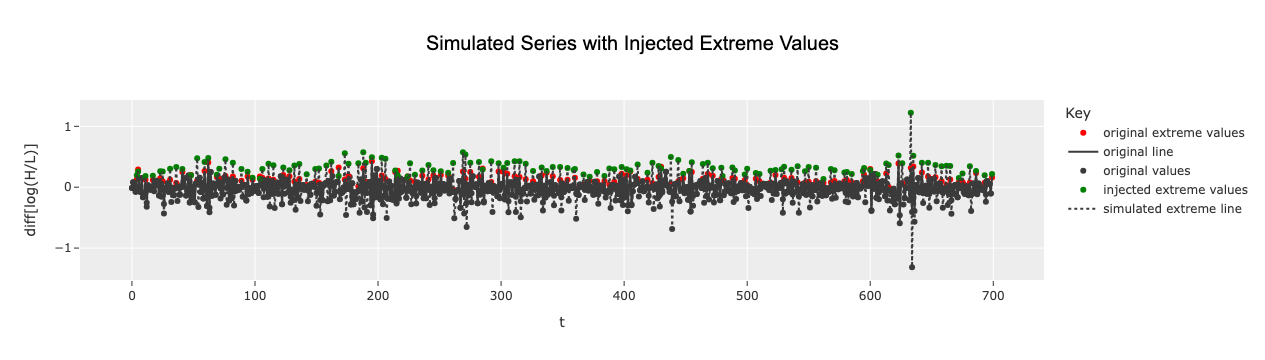

In [73]:
plot_extremes_compare(gen_df, x="t", y="data", y2="data_anom", color_col="max_flag", differenced = True)

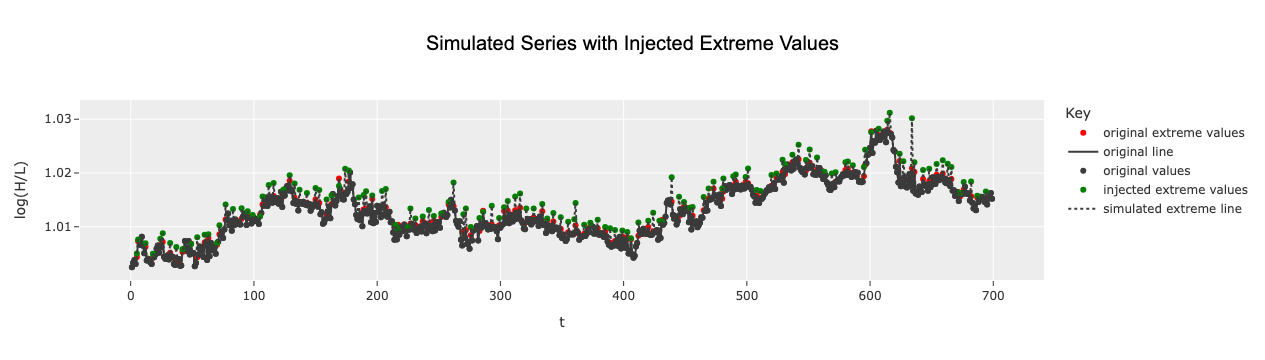

In [74]:
import numpy as np

#data_sim = DataSimulator(reference_data=pd.DataFrame(), init_value=np.nan)
gen_df["untransformed"] = data_sim.transform_hl_diff_series(gen_df.data)
gen_df["untransformed_ext"] = data_sim.transform_hl_diff_series(gen_df.data_anom)
gen_df["max_flag_shifted"] = gen_df["max_flag_str"].shift(1)

plot_extremes_compare(gen_df, x="t", y="untransformed", y2="untransformed_ext", color_col="max_flag_shifted", differenced = False)

In [73]:
gen_ref_df = pd.read_sql("select * from sim_data_distribution_reference_700 where id = 831687877722", conn)

In [74]:
gen_ref_df

,index,model,parameters_c,parameters_loc,parameters_scale,id
0,0,genextreme,-0.076027,2.323725,2.179566,831687877722
1,1,genextreme,-0.046607,0.323161,0.762799,831687877722


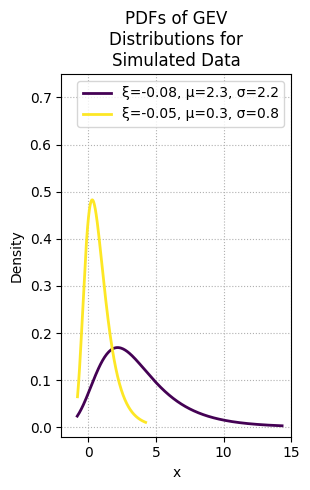

In [92]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import genextreme

plt.figure(figsize=(3.2, 5))

# Use a colormap for different colors
colors = plt.cm.viridis(np.linspace(0, 1, len(gen_ref_df)))

for i, (ind, row) in enumerate(gen_ref_df.iterrows()):
    c = row['parameters_c']
    loc = row['parameters_loc']
    scale = row['parameters_scale']

    # Generate x-values safely within distribution support
    x = np.linspace(
        genextreme.ppf(0.01, c, loc=loc, scale=scale),
        genextreme.ppf(0.99, c, loc=loc, scale=scale),
        300
    )
    y = genextreme.pdf(x, c, loc=loc, scale=scale)

    # Create label with chunk start and end dates
    label = f"ξ={c:.2f}, μ={loc:.1f}, σ={scale:.1f}"

    plt.plot(x, y, lw=2, color=colors[i], label=label)

plt.xlim(-2, 15)
plt.ylim(-0.02, 0.75)
plt.title('PDFs of GEV\nDistributions for\nSimulated Data')
plt.xlabel('x')
plt.ylabel('Density')
plt.legend()
plt.grid(True, linestyle=':')
plt.tight_layout()
plt.show()

## Anomalous dataset generation

In [15]:
from data_simulator import DataSimulator
from data_simulator import (plot_extremes_compare, plot_genextreme_distributions, 
                            generate_genextreme_distributions, compute_genextreme_relative_entropy, 
                            encode_strings_to_id, get_reference_data)

### (1) Test Case

In [10]:
ref_data, ref_init_val = get_reference_data("CZR", "2018-02-25", "2019-12-06", mkt_utils)

In [11]:
data_sim = DataSimulator(reference_data=ref_data, init_value=ref_init_val)

In [ ]:
gen_df = data_sim.generate_anomaly_series(nob_num=700, as_dataframe=True)

In [ ]:
gen_df = data_sim.generate_anomaly_series(as_dataframe=True)
gen_df["untransformed"] = data_sim.transform_hl_diff_series(gen_df.data)
gen_df["untransformed_ext"] = data_sim.transform_hl_diff_series(gen_df.data_ext)
gen_df["max_flag_shifted"] = gen_df["max_flag_anomaly"].astype(str).shift(1)

In [ ]:
plot_extremes_compare(gen_df, x="t", y="data", y2="data_ext", color_col="max_flag_anomaly", differenced = True)

In [ ]:
plot_extremes_compare(gen_df, x="t", y="untransformed", y2="untransformed_ext", color_col="max_flag_shifted", differenced = False)

### (2) Compare to real-world data

In [ ]:
anomaly_qry = """
        select eir.ticker, eir.current_date, eir.highlow_score, eir.highlow_pvalue, eir.openclose_score, eir.openclose_pvalue 
        from ev_interday_results_2 eir 
        join manual_anomalies ma
        on eir.ticker = ma.symbol
        and eir.current_date = ma.date 
        and ma.classification = 'Anomaly'
        where eir.highlow_score is not null
        and eir.highlow_score < 0.1
        and eir.openclose_score > 0.4
    """
anom_df = pd.read_sql(anomaly_qry, conn)

In [ ]:
len(anom_df.sort_values("current_date", ascending=False))

In [ ]:
bfri_data, _ = get_reference_data("BFRI", mkt_utils.get_before_date("2023-10-19", 100), mkt_utils.get_after_date("2023-10-19", 50), mkt_utils)

In [ ]:
bfri_data["log_highlow_diff"].plot()

### (3) Build dataset

In [5]:
sym_date_pair_query = """
    WITH numbered AS (
        SELECT 
            t.*,
            ROW_NUMBER() OVER (PARTITION BY symbol ORDER BY chunk_end_date) AS rn
        FROM iterative_ev_kl_5D t
        WHERE chunk_start_date > '2000-01-01'
        AND chunk_end_date < '2020-01-31'
    )
    SELECT distinct curr.symbol, curr.chunk_start_date, curr.chunk_end_date, curr.kl_divergence
    FROM numbered curr
    JOIN numbered p1 ON (p1.rn = curr.rn - 1 and p1.symbol = curr.symbol)
    JOIN numbered p2 ON (p2.rn = curr.rn - 2 and p2.symbol = curr.symbol)
    JOIN numbered p3 ON (p3.rn = curr.rn - 3 and p3.symbol = curr.symbol)
    JOIN numbered n1 ON (n1.rn = curr.rn + 1 and n1.symbol = curr.symbol)
    JOIN numbered n2 ON (n2.rn = curr.rn + 2 and n2.symbol = curr.symbol)
    JOIN numbered n3 ON (n3.rn = curr.rn + 3 and n3.symbol = curr.symbol)
    WHERE curr.kl_divergence < 0.1
      AND p1.kl_divergence < 0.1
      AND p2.kl_divergence < 0.1
      AND p3.kl_divergence < 0.1
      AND n1.kl_divergence < 0.1
      AND n2.kl_divergence < 0.1
      AND n3.kl_divergence < 0.1;
  """
sym_date_pair_df = pd.read_sql(sym_date_pair_query, conn)

In [16]:
import random
from tqdm import tqdm
import numpy as np
import time

try:
    existing_df = pd.read_sql("select distinct id from sim_data_anomaly_700", conn)
    existing_ids = existing_df['id'].to_list()
except:
    existing_ids = [] 
    
n_samples = 70 - len(existing_ids)
i = 0
symbol_options = list(sym_date_pair_df.symbol.unique())
new_ids_anom = []
random.shuffle(symbol_options)

while (i < n_samples) and (len(symbol_options) > 0):
    print()
    print("-- ITERATION", (i+1), "/", n_samples, "--")
    
    # get parameters
    reference_symbol = symbol_options.pop()
    sym_arr = sym_date_pair_df[sym_date_pair_df["symbol"] == reference_symbol].to_numpy()
    row = sym_arr[np.random.randint(0, sym_arr.shape[0])]

    # choose a random number of standard deviations to use
    num_std = random.uniform(3.5, 6)

    # get the start date and end date
    try:
        start_dt = mkt_utils.get_before_date(row[1], 100)
        end_dt = row[2]
    except:
        continue

    # print reference
    print(reference_symbol, start_dt, end_dt)

    # get reference data ID
    ref_id = encode_strings_to_id(reference_symbol, start_dt, end_dt)

    # do not duplicate
    if ref_id in existing_ids:
        continue

    # get reference data
    try:
        reference_data, reference_init_val = get_reference_data(reference_symbol, start_dt, end_dt, mkt_utils)
    except:
        print("Reference data error")
        continue
    
    # initiate data simulator
    data_sim = DataSimulator(reference_data=reference_data, init_value=reference_init_val)

    # get simulated data with anomalous observations
    try:
        sim_data = data_sim.generate_anomaly_series(n_std = 5, nob_num = 700, cutoff_ind_pre = 400, cutoff_ind_post = 50, as_dataframe=True, verbose=True)
    except Exception as e:
        continue
        
    # add ID column
    sim_data["id"] = ref_id
    new_ids_anom.append(ref_id)

    # load to database
    sim_data.to_sql("sim_data_anomaly_700", conn, if_exists='append', index=False)

    i += 1


-- ITERATION 1 / 11 --
CVCY 2017-06-08 2018-08-15

-- ITERATION 1 / 11 --
NAVI 2015-07-27 2016-09-30

-- ITERATION 1 / 11 --
FCCY 2014-09-30 2016-01-28

-- ITERATION 1 / 11 --
OSBC 2008-04-10 2009-06-17

-- ITERATION 1 / 11 --
BHF 2017-08-22 2018-10-29

-- ITERATION 1 / 11 --
SSSS 2018-04-13 2019-06-21
Reference data error

-- ITERATION 1 / 11 --
SIBN 2018-10-04 2019-12-12

-- ITERATION 1 / 11 --
ACBI 2018-07-18 2019-09-25

-- ITERATION 1 / 11 --
ULBI 2017-10-30 2019-01-09

-- ITERATION 1 / 11 --
SABR 2016-03-31 2017-06-07

-- ITERATION 1 / 11 --
DGRE 2017-04-06 2018-06-14
Generated valid simulated dataframe.

-- ITERATION 2 / 11 --
SRET 2015-11-27 2017-02-06

-- ITERATION 2 / 11 --
OKTA 2017-09-29 2018-12-07

-- ITERATION 2 / 11 --
ATRO 2006-05-05 2007-07-16

-- ITERATION 2 / 11 --
ESQ 2017-06-14 2018-08-30

-- ITERATION 2 / 11 --
EWZS 2014-03-18 2015-05-26
Generated valid simulated dataframe.

-- ITERATION 3 / 11 --
LIND 2018-08-08 2019-10-16

-- ITERATION 3 / 11 --
BANX 2017-10-16 

In [17]:
new_ids_anom

[745720918744,
 174894276825,
 945539516964,
 541347502084,
 287190571734,
 517974703589,
 994210095501,
 122986524029,
 545284215698,
 762652409636,
 685997514079]

### Examine Anomalous Data

In [93]:
pd.read_sql("select distinct id from sim_data_anomaly_700", conn)

,id
0,206838503019
1,874966003042
2,12826756181
3,935669599404
4,670419934837
...,...
65,994210095501
66,122986524029
67,545284215698
68,762652409636


In [97]:
anom_df = pd.read_sql("select * from sim_data_anomaly_700 where id = 206838503019", conn)

In [98]:
anom_df["volatility"].describe()

count    700.000000
mean       0.792358
std        0.064923
min        0.710328
25%        0.745296
50%        0.776944
75%        0.821549
max        1.218263
Name: volatility, dtype: float64

In [99]:
anom_df["untransformed"] = data_sim.transform_hl_diff_series(anom_df.data)
anom_df["untransformed_ext"] = data_sim.transform_hl_diff_series(anom_df.data_ext)
anom_df["max_flag_shifted"] = anom_df["max_flag_anomaly"].astype(str).shift(1)

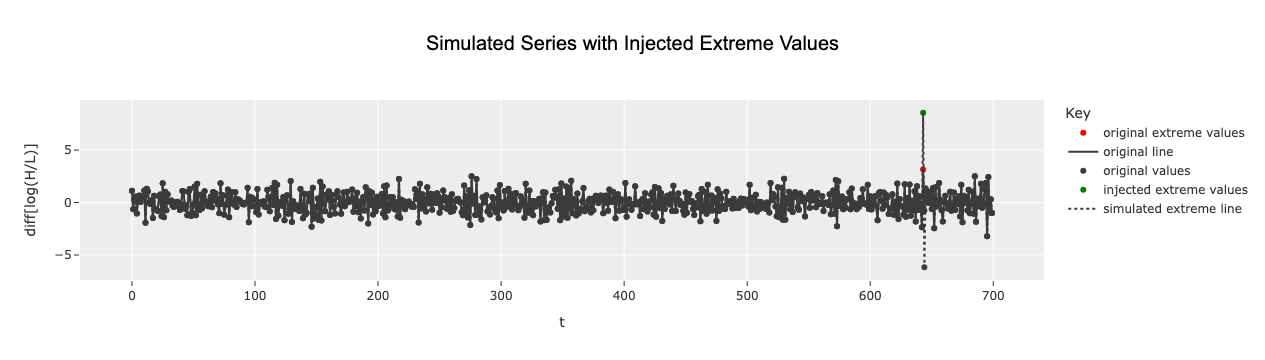

In [100]:
plot_extremes_compare(anom_df, x="t", y="data", y2="data_ext", color_col="max_flag_anomaly", differenced = True)

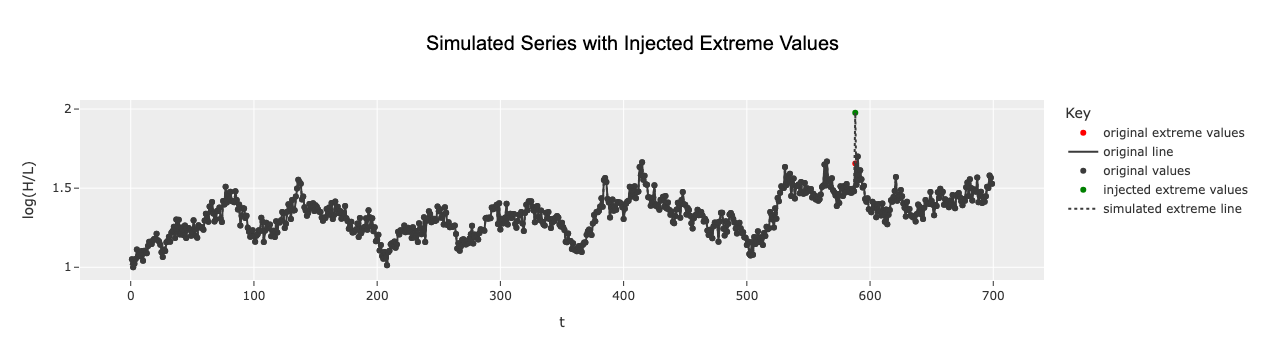

In [46]:
plot_extremes_compare(anom_df, x="t", y="untransformed", y2="untransformed_ext", color_col="max_flag_shifted", differenced = False)

## Misc. Notes

**Transform this back to a candlestick-type chart to visualize the feasability of such a series**

1. Get a mean value for the log(H/L) ratio.

In [ ]:
czr_subset = czr_df[(czr_df.dlycaldt >= '2019-03-25') & (czr_df.dlycaldt <= '2020-01-07')].copy().reset_index(drop=True)

In [ ]:
czr_subset["hl_ratio"] = np.exp(czr_subset["log_highlow"])

In [ ]:
czr_subset["hl_ratio"].iloc[-1]

In [ ]:
low_mean = czr_subset["dlylow"].mean()
high_mean = czr_subset["dlyhigh"].mean()

In [ ]:
initial_ratio = round(round(high_mean,2)/round(low_mean,2), 2) # round to two decimal points to be realistic

In [ ]:
initial_ratio # get the inital ratio

In [ ]:
czr_subset.hl_ratio.mean() # compare this to the true mean

In [ ]:
czr_subset.hl_ratio.describe()

Process:
1. Divide ``log_highlow_diff`` by 100 (since it is scaled by 100) 
2. Exponentiate ``log_highlow_diff`` to remove the log, this gives us $\frac{H_{t}/L_{t}}{H_{t-1}/L_{t-1}}$
3. Set a $H_{0}/L_{0}$ value and use this to extract the remaining $H/L$ ratios.

In [ ]:
sim_data

In [ ]:
transformed_srs = np.exp(sim_data.data_ext/100)
untransformed_srs = np.exp(sim_data.data/100)

In [ ]:
transformed_srs[untransformed_srs < 1]

In [ ]:
czr_subset.hl_ratio.min()

In [ ]:
result_series = [float(initial_ratio)]
prev_val = float(initial_ratio)
for val in untransformed_srs[1:]:
    # val = (H_t / L_t)/(H_{t-1} / L_{t-1})
    untransformed_val = max(1, float(val) * prev_val)
    result_series.append(untransformed_val)

    # set prev_val to val
    prev_val = untransformed_val 

In [ ]:
pd.Series(result_series[:200]).plot()

In [ ]:
czr_subset.hl_ratio.plot()

**Transform the series back to enforce the minimum**

**Fit the extreme value distributions iteratively to the simulated data as a quality check**

In addition to this simple accept-reject algorithm based on the conditional standard deviation, to improve this algorithm, we should incorporate:
- (a) The mean element of the AR(1)-GARCH(1,1) model
- (b) Although this is somewhat baked into the GARCH model already, we can control for consecutive time deviations